In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

# Load each CSV file into a DataFrame and add a 'Year' column for the dataset's year
files = {
    "sold19.csv": 2019,
    "sold20.csv": 2020,
    "sold21.csv": 2021,
    "sold22.csv": 2022,
    "sold23.csv": 2023
}

dataframes = []

for file, year in files.items():
    df = pd.read_csv(file)  
    df['Year'] = year
    dataframes.append(df)

# Concatenate dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

# Drop empty columns
combined_df.drop(columns=['Unnamed: 0', 'Unnamed: 1'], inplace=True)

# Convert Price to float
combined_df['List Price'] = combined_df['List Price'].replace(r'[\$,]', '', regex=True).astype(float)
combined_df['Sold Price'] = combined_df['Sold Price'].replace(r'[\$,]', '', regex=True).astype(float)

# Convert Approx Living Area to float
combined_df['Approx Living Area'] = combined_df['Approx Living Area'].replace(',', '', regex=True).astype(float)

# Split Beds/Baths column 
combined_df[['Beds', 'Baths']] = combined_df['Beds/Baths'].str.extract(r'(\d+) Bed/(\d+)\(\d+\)').astype(float)

# Parse 'Sold Date' with the correct format
combined_df['Sold Date'] = pd.to_datetime(combined_df['Sold Date'], format='%m/%d/%y', errors='coerce')

# Drop rows with missing values
combined_df.dropna(inplace=True)

# Extract year from Sold Date
combined_df['Sold Year'] = combined_df['Sold Date'].dt.year

# Sort by 'Sold Year'
combined_df = combined_df.sort_values(by=['Sold Year'])

#
combined_df.head()



,List Price,Address,City,Beds/Baths,Approx Living Area,DOM,Sold Price,Sold Date,Year,Beds,Baths,Sold Year
0,19750.0,4627 FRIDEN DR,JACKSONVILLE,2 Bed/1(0),688.0,20,17500.0,2019-08-23,2019,2.0,1.0,2019
2898,299900.0,12317 DAVIS BLVD,FORT MYERS,3 Bed/2(0),1342.0,24,299000.0,2019-12-13,2019,3.0,2.0,2019
2899,299000.0,2965 COCO AVE,NAPLES,2 Bed/1(1),1175.0,49,299000.0,2019-11-13,2019,2.0,1.0,2019
2900,299900.0,3630 8TH AVE SE,NAPLES,3 Bed/2(0),1701.0,14,299000.0,2019-08-23,2019,3.0,2.0,2019
2901,309900.0,2935 28TH AVE SE,NAPLES,3 Bed/2(0),1498.0,11,299000.0,2019-08-16,2019,3.0,2.0,2019


In [31]:
# Group by 'Sold Year' - calculate median 'Sold Price' for each year
median_sold_price = combined_df.groupby('Sold Year')['Sold Price'].median()

# Convert df
median_sold_price_df = median_sold_price.reset_index()

# Rename column
median_sold_price_df.rename(columns={'Sold Price': 'Median Sold Price'}, inplace=True)

# Merge median sold price 
combined_df = combined_df.merge(median_sold_price_df, on='Sold Year', how='left')

# Check result
print(combined_df[['Address', 'Sold Year', 'Median Sold Price']].head())


            Address  Sold Year  Median Sold Price
0    4627 FRIDEN DR       2019           250000.0
1  12317 DAVIS BLVD       2019           250000.0
2     2965 COCO AVE       2019           250000.0
3   3630 8TH AVE SE       2019           250000.0
4  2935 28TH AVE SE       2019           250000.0


In [32]:
# Add a column to calculate the difference
combined_df['Price Difference'] = combined_df['Sold Price'] - combined_df['Median Sold Price']

# Check result
print(combined_df[['Address', 'Sold Year', 'Sold Price', 'Median Sold Price', 'Price Difference']].head())

            Address  Sold Year  Sold Price  Median Sold Price  \
0    4627 FRIDEN DR       2019     17500.0           250000.0   
1  12317 DAVIS BLVD       2019    299000.0           250000.0   
2     2965 COCO AVE       2019    299000.0           250000.0   
3   3630 8TH AVE SE       2019    299000.0           250000.0   
4  2935 28TH AVE SE       2019    299000.0           250000.0   

   Price Difference  
0         -232500.0  
1           49000.0  
2           49000.0  
3           49000.0  
4           49000.0  


In [33]:
stats_sold_price = combined_df.groupby('Sold Year')['Sold Price'].agg(['mean', 'std', 'median']).reset_index()
stats_sold_price.rename(columns={'mean': 'Mean Sold Price', 'std': 'STD Sold Price', 'median': 'Median Sold Price'}, inplace=True)
if 'Median Sold Price' in combined_df.columns:
    combined_df.drop(columns=['Median Sold Price'], inplace=True)
combined_df = combined_df.merge(stats_sold_price, on='Sold Year', how='left')


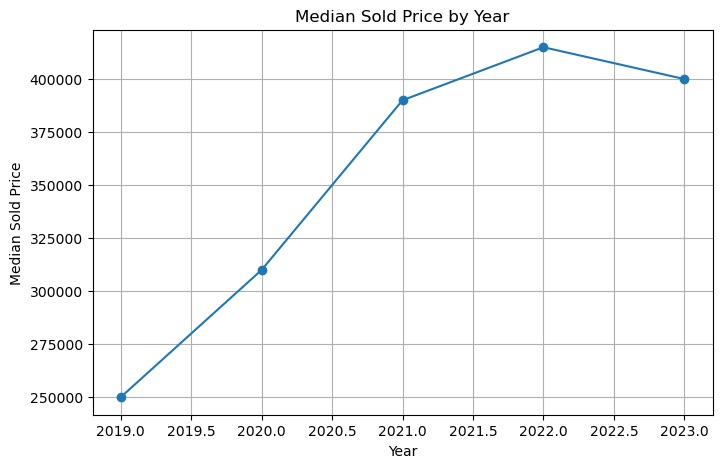

In [34]:
# plot median sold price by year
plt.figure(figsize=(8, 5))
plt.plot(median_sold_price_df['Sold Year'], median_sold_price_df['Median Sold Price'], marker='o')
plt.title('Median Sold Price by Year')
plt.xlabel('Year')
plt.ylabel('Median Sold Price')
plt.grid(True)
plt.show()


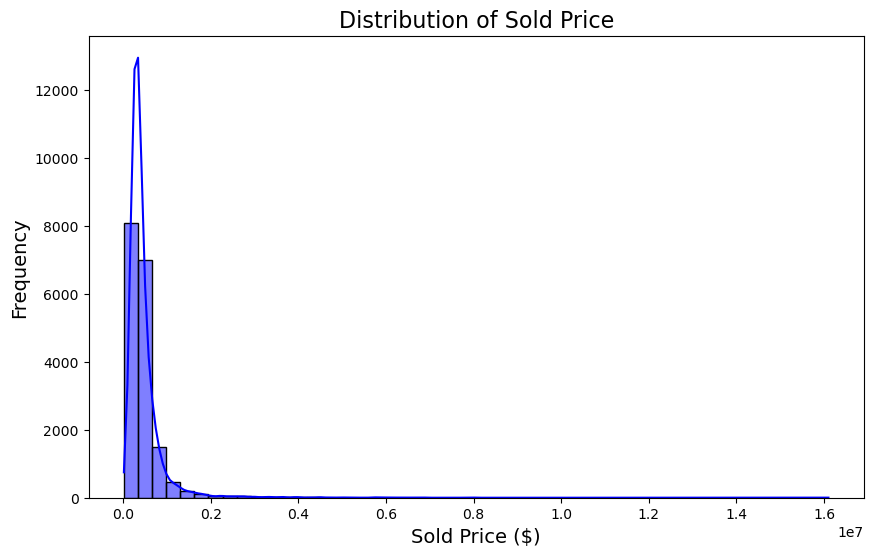

In [35]:
# Plot Sold Price Values Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x='Sold Price', bins=50, kde=True, color='blue')

plt.title('Distribution of Sold Price', fontsize=16)
plt.xlabel('Sold Price ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show plot
plt.show()


In [36]:
# Calculate ppsf
combined_df['Price per SqFt'] = combined_df['Sold Price'] / combined_df['Approx Living Area']

# Check result
print(combined_df[['Address', 'Sold Price', 'Approx Living Area', 'Price per SqFt']].head())


            Address  Sold Price  Approx Living Area  Price per SqFt
0    4627 FRIDEN DR     17500.0               688.0       25.436047
1  12317 DAVIS BLVD    299000.0              1342.0      222.801788
2     2965 COCO AVE    299000.0              1175.0      254.468085
3   3630 8TH AVE SE    299000.0              1701.0      175.778954
4  2935 28TH AVE SE    299000.0              1498.0      199.599466


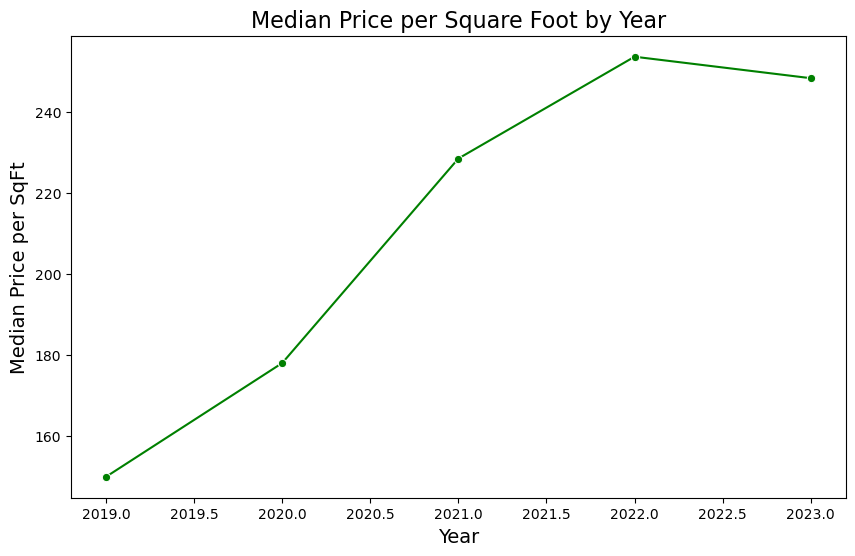

In [37]:
# Calculate median ppsf for each year
median_price_per_sqft = combined_df.groupby('Sold Year')['Price per SqFt'].median()

# Convert df
median_price_per_sqft_df = median_price_per_sqft.reset_index()

# Rename column
median_price_per_sqft_df.rename(columns={'Price per SqFt': 'Median Price per SqFt'}, inplace=True)

# Plot Median Price per Square Foot by Year
plt.figure(figsize=(10, 6))
sns.lineplot(data=median_price_per_sqft_df, x='Sold Year', y='Median Price per SqFt', marker='o', color='g')

plt.title('Median Price per Square Foot by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Median Price per SqFt', fontsize=14)

# Show plot
plt.show()


In [38]:
# Rename the median ppsf column
median_price_per_sqft_df.rename(columns={'Price per SqFt': 'Median Price per SqFt'}, inplace=True)

# Merge median ppsf with df
combined_df = combined_df.merge(median_price_per_sqft_df, on='Sold Year', how='left')

# Check result
print(combined_df[['Address', 'Sold Year', 'Price per SqFt', 'Median Price per SqFt']].head())


            Address  Sold Year  Price per SqFt  Median Price per SqFt
0    4627 FRIDEN DR       2019       25.436047             149.934811
1  12317 DAVIS BLVD       2019      222.801788             149.934811
2     2965 COCO AVE       2019      254.468085             149.934811
3   3630 8TH AVE SE       2019      175.778954             149.934811
4  2935 28TH AVE SE       2019      199.599466             149.934811


In [39]:
print(combined_df.columns)

Index(['List Price', 'Address', 'City', 'Beds/Baths', 'Approx Living Area',
       'DOM', 'Sold Price', 'Sold Date', 'Year', 'Beds', 'Baths', 'Sold Year',
       'Price Difference', 'Mean Sold Price', 'STD Sold Price',
       'Median Sold Price', 'Price per SqFt', 'Median Price per SqFt'],
      dtype='object')


In [40]:
# encode categorical values
df_encoded = pd.get_dummies(df, columns=['Address', 'City'])

# Select features for the model
features = ['Approx Living Area', 'Beds', 'Baths', 'Price per SqFt', 'Median Price per SqFt']
target = 'Sold Price'

# Drop rows with missing values in features or target
df_model = combined_df[features + [target]].dropna()

# Split into features (X) and target (y)
X = df_model[features]
y = df_model[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shapes of X_train and y_train
print(X_train.shape, y_train.shape)


(14043, 5) (14043,)


In [41]:
# Clean data

X_train_clean = X_train[~np.isinf(X_train).any(axis=1)]  # Remove rows with inf values in any column
y_train_clean = y_train[X_train_clean.index]  # Ensure y_train corresponds to the cleaned X_train

X_test_clean = X_test[~np.isinf(X_test).any(axis=1)]  # Same for X_test
y_test_clean = y_test[X_test_clean.index]  # Ensure y_test corresponds to the cleaned X_test

# Remove rows with NaN values in features
X_train_clean = X_train_clean.dropna()
y_train_clean = y_train_clean[X_train_clean.index]

X_test_clean = X_test_clean.dropna()
y_test_clean = y_test_clean[X_test_clean.index]


RMSE: 97300.69
R²: 0.97


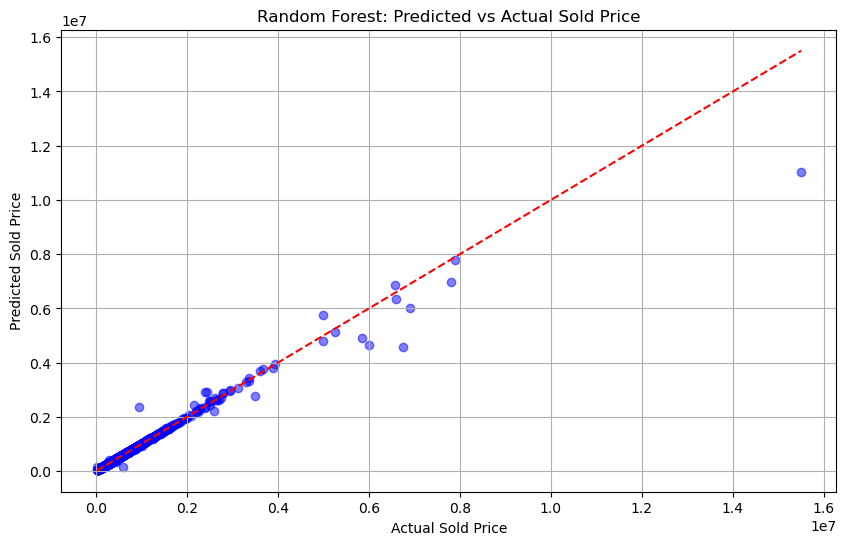

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_clean, y_train_clean)

# Predict on the test set
y_pred = model.predict(X_test_clean)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred))
r2 = r2_score(y_test_clean, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Plot the predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Random Forest: Predicted vs Actual Sold Price')
plt.xlabel('Actual Sold Price')
plt.ylabel('Predicted Sold Price')
plt.grid(True)
plt.show()


Root mean squared error of $97,300.69 - good for wide range of values, but not for median sold price 
Model explains 97% of variance in Sold Price

Linear Regression RMSE: 480682.55
Linear Regression R²: 0.24


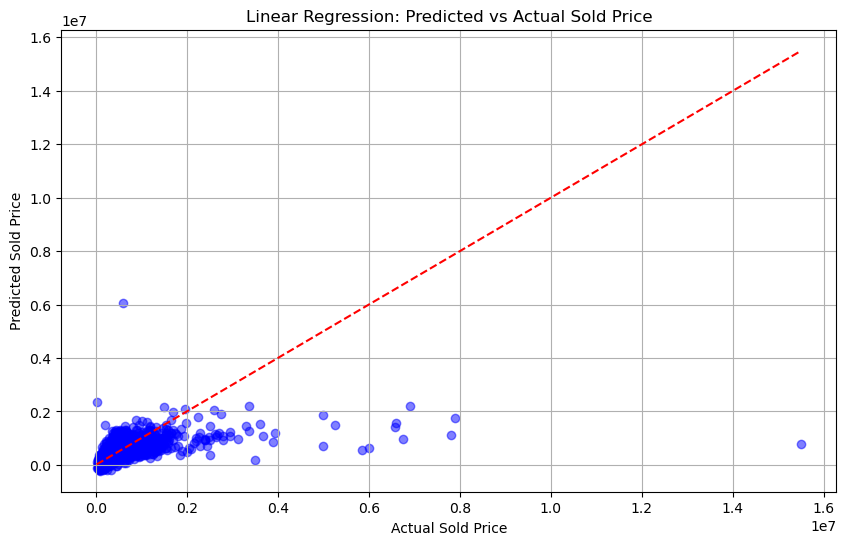

In [43]:
from sklearn.linear_model import LinearRegression

# Initialize linear regression model
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_clean, y_train_clean)

# Predict on the test set
y_pred = linear_model.predict(X_test_clean)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred))
r2 = r2_score(y_test_clean, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"Linear Regression R²: {r2:.2f}")

# Plot the predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Linear Regression: Predicted vs Actual Sold Price')
plt.xlabel('Actual Sold Price')
plt.ylabel('Predicted Sold Price')
plt.grid(True)
plt.show()

Poor RMSE and R^2 values

SVM RMSE: 563681.20
SVM R²: -0.05


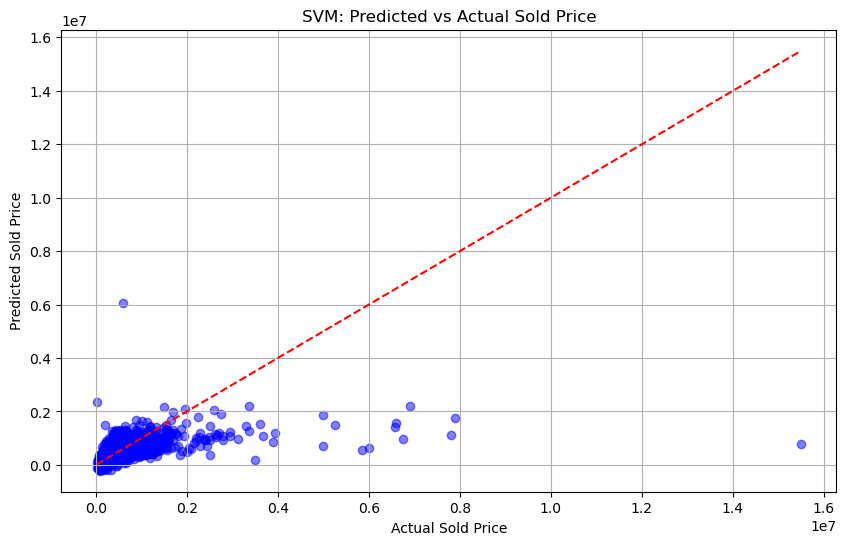

In [44]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the training and test data
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)


# Initialize the model with a radial basis function (RBF) kernel
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)

# Train the model
svm_model.fit(X_train_scaled, y_train_clean)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test_scaled)

# Calculate performance metrics
rmse_svm = np.sqrt(mean_squared_error(y_test_clean, y_pred_svm))
r2_svm = r2_score(y_test_clean, y_pred_svm)

print(f"SVM RMSE: {rmse_svm:.2f}")
print(f"SVM R²: {r2_svm:.2f}")

# Plot the predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('SVM: Predicted vs Actual Sold Price')
plt.xlabel('Actual Sold Price')
plt.ylabel('Predicted Sold Price')
plt.grid(True)
plt.show()

XGBoost RMSE: 197062.95
XGBoost R²: 0.87


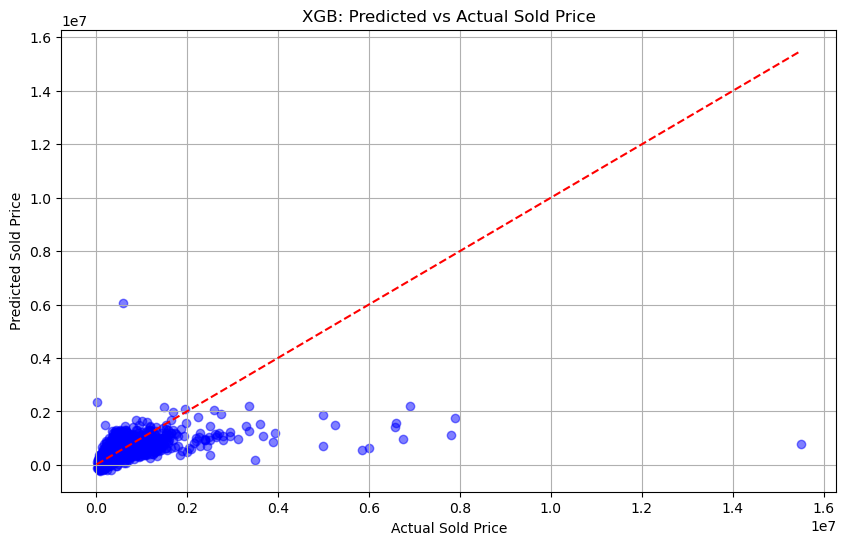

In [45]:
import xgboost as xgb

# Initialize the model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Train the model
xgb_model.fit(X_train_scaled, y_train_clean)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Calculate performance metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test_clean, y_pred_xgb))
r2_xgb = r2_score(y_test_clean, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost R²: {r2_xgb:.2f}")

# Plot the predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('XGB: Predicted vs Actual Sold Price')
plt.xlabel('Actual Sold Price')
plt.ylabel('Predicted Sold Price')
plt.grid(True)
plt.show()

In [46]:
# Define investment criteria
combined_df['Investment Criteria'] = (
    (combined_df['Price per SqFt'] < combined_df['Median Price per SqFt']) &
    (combined_df['Sold Price'] < combined_df['Median Sold Price'])
)

# 'Good' and 'Bad' for boolean
combined_df['Investment Criteria'] = combined_df['Investment Criteria'].map({True: 'Good', False: 'Bad'})

# Check result
print(combined_df[['Address', 'Sold Year', 'Price per SqFt', 'Sold Price', 'Median Sold Price', 'Median Price per SqFt', 'Investment Criteria']].head())


            Address  Sold Year  Price per SqFt  Sold Price  Median Sold Price  \
0    4627 FRIDEN DR       2019       25.436047     17500.0           250000.0   
1  12317 DAVIS BLVD       2019      222.801788    299000.0           250000.0   
2     2965 COCO AVE       2019      254.468085    299000.0           250000.0   
3   3630 8TH AVE SE       2019      175.778954    299000.0           250000.0   
4  2935 28TH AVE SE       2019      199.599466    299000.0           250000.0   

   Median Price per SqFt Investment Criteria  
0             149.934811                Good  
1             149.934811                 Bad  
2             149.934811                 Bad  
3             149.934811                 Bad  
4             149.934811                 Bad  
